# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import utils

from transformers import T5Tokenizer
from unidecode import unidecode

/opt/anaconda3/envs/thesis/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Compute length stats

## Useful functions

In [2]:
def get_all_examples(task_name: str) -> list:
    examples = []
    prefix = utils.get_task_prefixes('data', task_name)[0]
    for suffix in ['_train.tsv', '_dev.tsv', '_test.tsv']:
        with open(os.path.join('data', task_name, prefix + suffix), encoding="utf-8") as fin:
            lines = fin.readlines()
        for line in lines:
            d = unidecode(line).strip().split("\t")
            examples.append([d[0], d[1:]])
    return examples

def plot_hist(df, task_name, n_bins=40):
    n, bins, patches = plt.hist(df[df['task_name'] == task_name].iloc[0]['all_lengths'], n_bins)
    plt.show()

## Main

In [3]:
class TrainingArgs:
    def __init__(self):
        self.task_names = utils.get_tasks_list(
            'dataloader/custom_tasks_splits/train_classification_test_classification.json', 'train')
        self.t5_model = 't5-base'
        self.max_input_len = 1024

args = TrainingArgs()
tokenizer = T5Tokenizer.from_pretrained(args.t5_model, model_max_length=args.max_input_len)

data = []
for task_name in args.task_names:
    examples = get_all_examples(task_name)    
    tokenized_input = tokenizer([ex[0] for ex in examples])
    lengths = [len(x) for x in tokenized_input['input_ids']]

    data.append([
        task_name, len(examples), np.min(lengths), np.max(lengths),
        np.percentile(lengths, 25), np.percentile(lengths, 50), np.percentile(lengths, 75), lengths
    ])

stats_df = pd.DataFrame(
    data, columns=['task_name', 'n_examples', 'min_len', 'max_len', 'percentile25', 'percentile50', 'percentile75', 'all_lengths'])

stats_df[['task_name', 'n_examples', 'min_len', 'max_len', 'percentile25', 'percentile50', 'percentile75']]

Token indices sequence length is longer than the specified maximum sequence length for this model (1484 > 1024). Running this sequence through the model will result in indexing errors


,task_name,n_examples,min_len,max_len,percentile25,percentile50,percentile75
0,superglue-rte,341,22,279,49.0,63.0,95.00
1,tweet_eval-sentiment,2096,9,100,28.0,34.0,40.00
2,discovery,14268,14,140,42.0,53.0,64.00
3,glue-rte,341,23,280,50.0,64.0,96.00
4,superglue-wsc,168,20,137,32.0,42.5,67.00
5,scicite,1014,6,655,56.0,73.0,94.00
6,glue-mrpc,472,31,109,55.0,66.5,77.25
7,tweet_eval-stance_hillary,165,16,64,28.0,35.0,41.00
8,tweet_eval-offensive,1388,6,146,20.0,33.0,56.00
9,emotion,2192,5,90,16.0,24.0,34.00


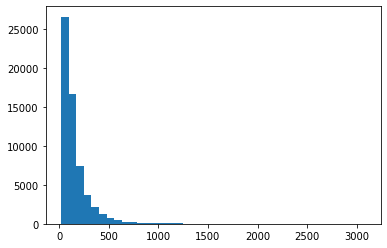

In [13]:
plot_hist(stats_df, 'yahoo_answers_topics')

# Generate prompt prefix

## Useful functions

In [6]:
instructions_dict = {}
with open('instruction/instructions_io_sep.tsv') as fin:
    lines = fin.readlines()
for line in lines:
    splits = line.strip().split('\t')
    instructions_dict[splits[0]] = splits[1], splits[2]

def get_instructions_and_io_sep(task_name):
    return instructions_dict[task_name]


## Main

In [10]:
class TrainingArgs:
    def __init__(self):
        self.task_names = ["superglue-rte", "yahoo_answers_topics"]
        self.data_dir = 'data'
        self.t5_model = 't5-base'
        self.k = 8
        self.max_input_len = 1024

args = TrainingArgs()

data = []
for task_name in args.task_names:
    prefixes = utils.get_task_prefixes(args.data_dir, task_name)
    for prefix in prefixes:
        # Get dev examples
        dev_examples = []
        with open(os.path.join(args.data_dir, task_name, prefix + "_dev.tsv"), encoding="utf-8") as fin:
            lines = fin.readlines()
        for line in lines:
            d = unidecode(line).strip().split("\t")
            dev_examples.append([d[0], d[1:]])
        
        # Construct prompt with demos and instructions
        demos = utils.sample_demos(dev_examples, args.k, None)
        instructions, io_sep = get_instructions_and_io_sep(task_name)
        prompt = instructions + '\n' + utils.create_input_text(demos, None, io_sep, '\n')

        data.append([
            task_name, prefix, prompt, len(tokenizer(prompt)['input_ids'])
        ])

prompt_df = pd.DataFrame(
    data, columns=['task_name', 'task_prefix', 'prompt', 'prompt_len'])


In [11]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    display(prompt_df)

,task_name,task_prefix,prompt,prompt_len
0,superglue-rte,superglue-rte_16_100,"Based on the premise, is the hypothesis true?\...",691
1,superglue-rte,superglue-rte_16_13,"Based on the premise, is the hypothesis true?\...",875
2,superglue-rte,superglue-rte_16_21,"Based on the premise, is the hypothesis true?\...",900
3,superglue-rte,superglue-rte_16_42,"Based on the premise, is the hypothesis true?\...",605
4,superglue-rte,superglue-rte_16_87,"Based on the premise, is the hypothesis true?\...",970
5,yahoo_answers_topics,yahoo_answers_topics_16_100,Classify the document into one of these topics...,1017
6,yahoo_answers_topics,yahoo_answers_topics_16_13,Classify the document into one of these topics...,1657
7,yahoo_answers_topics,yahoo_answers_topics_16_21,Classify the document into one of these topics...,1477
8,yahoo_answers_topics,yahoo_answers_topics_16_42,Classify the document into one of these topics...,2514
9,yahoo_answers_topics,yahoo_answers_topics_16_87,Classify the document into one of these topics...,2101


In [12]:
prompt_df.to_csv('instruction/test.tsv', index=False, sep='\t')
# To read: pd.read_csv('instruction/prompt.tsv', sep='\t', header=0)